# Sentiment analysis of Bluesky posts

In [175]:
import pandas as pd
import numpy as np
import snscrape.modules.twitter as sntwitter
from datetime import datetime
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt

## tweets

### load tweets

In [176]:
# loading museum visitor data - field museum??
import glob

path = 'tweets'
filenames = glob.glob(path + "/bristol*.csv")

dfs = []
for f in filenames:
    df = pd.read_csv(f)
    dfs.append(df)

tweets = pd.concat(dfs, ignore_index=True)

# tweets.head()
len(tweets)



6281

In [177]:
print("There are {} observations and {} features in this dataset. \n".format(tweets.shape[0],tweets.shape[1]))

There are 6281 observations and 15 features in this dataset. 



### Make a wordcloud

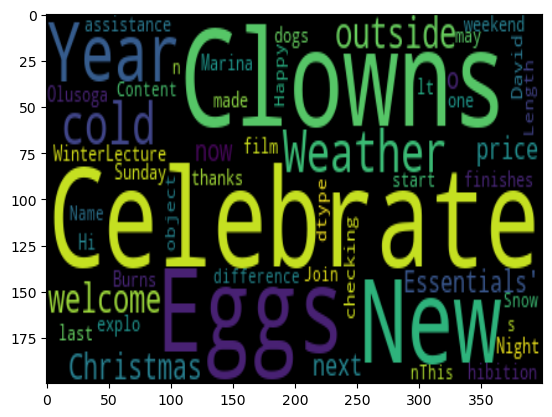

In [349]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = str(tweets['Content'])
# text = str(df.Content)

text = text.replace('Bristol Museum', '')
# text = re.sub('[Nn]atural|[Mm]useum|[Hh]istory', '', text)
# text = re.sub('[Nn]atural', '', text)
# text = re.sub('[Nn]atural', '', text)

wc = WordCloud().generate(text)

plt.imshow(wc, interpolation='bilinear', aspect='auto')

plt.savefig('figs/wordcloud.png', dpi=600)


## Do sentiment analysis on tweets



In [179]:
# sentiment analysis functions

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from nltk.corpus import stopwords
import re

def get_post_sentiment(post):
    # create TextBlob object of passed bluesky post text
    analysis = TextBlob(post)
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

def get_post_sentiment_value(post):
    # create TextBlob object of passed bluesky post text
    analysis = TextBlob(post)
    # set sentiment
    return analysis.sentiment.polarity

def get_post_sentiment_vad(post):
    # create TextBlob object of passed bluesky post text
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(post)
    # set sentiment
    if vs['compound'] > 0:
        return 'positive'
    elif vs['compound'] == 0:
        return 'neutral'
    else:
        return 'negative'

def get_post_sentiment_vad_value(post):
    # create TextBlob object of passed bluesky post text
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(post)
    # set sentiment
    return vs['compound']

# Remove URLs
def clean_tweets(text):
    STOPWORDS.add('death')
    text = re.sub(r'http\S+', '', text)
    return ' '.join([word for word in text.split() if word.lower() not in STOPWORDS])

# clean_tweets(text="hi there i'm chad")

In [180]:
tweets['Content_cleaned'] = tweets['Content'].apply(clean_tweets)

tweets.loc[:, ('Content_cleaned','Content')]

,Content_cleaned,Content
0,Weather cold outside welcome warmer Red Lodge,The Weather is cold outside but the welcome is...
1,'Christmas Essentials' now 1/2 price online sh...,All 'Christmas Essentials' are now 1/2 price o...
2,next #WinterLecture David Olusoga explores ear...,In our next #WinterLecture David Olusoga explo...
3,*assistance dogs is! ^lt,*assistance dogs that is! ^lt
4,"Hi Marina, thanks checking - assistance allowe...","Hi Marina, thanks for checking - however only ..."
...,...,...
6276,Celebrate last weekend Clowns: Eggs-hibition j...,Celebrate the last weekend of Clowns: the Eggs...
6277,clowns eggs-hibition finishes Sunday catch whi...,Our clowns eggs-hibition finishes on Sunday so...
6278,may made one film start & hosted 17 screenings...,I may have only made one film but I did start ...
6279,Celebrate Burns Night difference! Join us nigh...,Celebrate Burns Night with a difference! Join ...


### Now get sentiment

In [181]:
tweets['Sentiment'] = tweets['Content_cleaned'].apply(get_post_sentiment)
tweets['Sentiment_value'] = tweets['Content_cleaned'].apply(get_post_sentiment_value)
tweets.head()

# save output
# tweets.to_csv('data/processed/FieldMuseum_2023-03-25_2024-09-11.csv', index=False)

,Name,Handle,Timestamp,Verified,Content,Comments,Retweets,Likes,Analytics,Tags,Mentions,Emojis,Profile Image,Tweet Link,Tweet ID,Content_cleaned,Sentiment,Sentiment_value
0,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-30T09:05:08.000Z,False,The Weather is cold outside but the welcome is...,0,3,7,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94703078324...,tweet_id:947030783243497472,Weather cold outside welcome warmer Red Lodge,positive,0.05
1,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-29T09:00:44.000Z,False,All 'Christmas Essentials' are now 1/2 price o...,1,2,5,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94666729063...,tweet_id:946667290631770112,'Christmas Essentials' now 1/2 price online sh...,neutral,0.00
2,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T16:00:55.000Z,False,In our next #WinterLecture David Olusoga explo...,0,0,8,0,['#WinterLecture'],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94641064325...,tweet_id:946410643258822656,next #WinterLecture David Olusoga explores ear...,positive,0.12
3,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T13:57:31.000Z,False,*assistance dogs that is! ^lt,0,0,0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94637958779...,tweet_id:946379587793096705,*assistance dogs is! ^lt,neutral,0.00
4,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T13:56:17.000Z,False,"Hi Marina, thanks for checking - however only ...",2,0,0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94637928036...,tweet_id:946379280363159552,"Hi Marina, thanks checking - assistance allowe...",positive,0.20


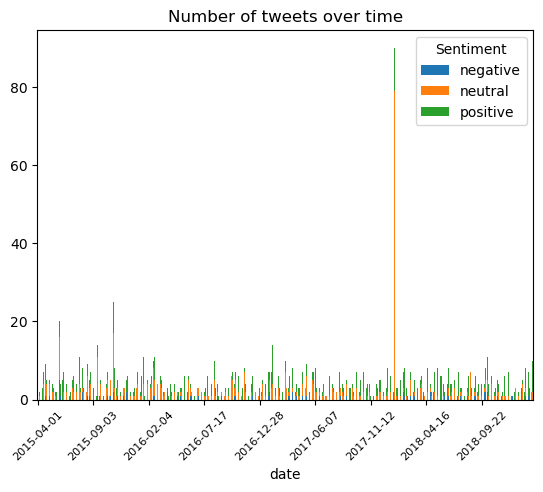

In [182]:
# now plot as a function of time and sentiment:

import seaborn as sns
import pandas as pd
import datetime as dt

tweets['date'] = pd.to_datetime(tweets['Timestamp']).dt.date

# Summarize number of rows by date and sentiment
summary_by_date = tweets.groupby([tweets['date'], 'Sentiment']).size().reset_index(name='counts')

# Line plot
# sns.lineplot(data=summary_by_date, x='date', y='counts', hue='Sentiment')
# plt.xticks(rotation=45, fontsize=8)

# Bar plot
summary_by_date.pivot(index='date', columns='Sentiment', values='counts').plot(kind='bar', stacked=True)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))

plt.xticks(rotation=45, fontsize=8)
plt.title('Number of tweets over time')

# save figure
plt.savefig('figs/timeline_sentiment_bristol.png', dpi=300)

In [183]:
# summary_by_date.sort_values('counts', ascending=False)
tweets.groupby(tweets['date']).size().sort_values(ascending=False)

date
2018-01-17    90
2017-10-16    40
2015-10-28    34
2017-12-24    30
2015-09-17    29
              ..
2016-10-31     1
2018-07-16     1
2015-05-01     1
2018-01-05     1
2017-03-06     1
Length: 1341, dtype: int64

Composite variables to calculate:

1. public engagement = likes + retweets + tweets
2. public perception = average sentiment value
3. advertisement = number of tweets from @bristolmuseum

In [184]:
from statistics import mean

# now we can plot the number of tweets and the number of visitors

tweets['date'] = pd.to_datetime(tweets['Timestamp']).dt.date

# Convert 'Retweets' and 'Likes' to numeric types
tweets['Retweets'] = pd.to_numeric(tweets['Retweets'], errors='coerce')
tweets['Likes'] = pd.to_numeric(tweets['Likes'], errors='coerce')

# Summarize total, neutral, positive, and negative tweets by date
tweet_summary_by_date = tweets.groupby('date').agg(
    self_counts=('Content', lambda x: sum((tweets.loc[x.index, 'Handle'] == '@bristolmuseum'))),
    total_counts=('Content', lambda x: sum((tweets.loc[x.index, 'Handle'] != '@bristolmuseum'))),
    likes_counts=('Likes', lambda x: sum(x)),
    retweet_counts=('Retweets', lambda x: sum(x)),
    # avg_sentiment=('Sentiment_value', lambda x: mean(x[tweets.loc[x.index, 'Handle'] != '@bristolmuseum'])),
    neutral_counts=('Sentiment', lambda x: sum((tweets.loc[x.index, 'Handle'] != '@bristolmuseum') & (x == 'neutral'))),
    positive_counts=('Sentiment', lambda x: sum((tweets.loc[x.index, 'Handle'] != '@bristolmuseum') & (x == 'positive'))),
    negative_counts=('Sentiment', lambda x: sum((tweets.loc[x.index, 'Handle'] != '@bristolmuseum') & (x == 'negative')))
).reset_index()

tweet_summary_by_date = tweet_summary_by_date.set_index('date')

tweet_summary_by_date.head()



,self_counts,total_counts,likes_counts,retweet_counts,neutral_counts,positive_counts,negative_counts
date,,,,,,,
2015-04-01,5,5,9.0,11.0,3,2,0
2015-04-02,4,9,22.0,42.0,3,0,6
2015-04-03,2,3,3.0,3.0,0,1,2
2015-04-04,3,2,12.0,5.0,1,0,1
2015-04-05,1,3,5.0,2.0,1,2,0


In [185]:
avg_sent = tweets[tweets['Handle'] != "@bristolmuseum"].groupby('date').Sentiment_value.mean()
# avg_sentiment=('Sentiment_value', lambda x: mean(x[tweets.loc[x.index, 'Handle'] != '@bristolmuseum'])),

avg_sent = avg_sent.reset_index()
avg_sent = avg_sent.set_index('date')

tweet_summary_by_date = pd.concat([tweet_summary_by_date, avg_sent], axis=1)
tweet_summary_by_date.reset_index(inplace=True)
tweet_summary_by_date



,date,self_counts,total_counts,likes_counts,retweet_counts,neutral_counts,positive_counts,negative_counts,Sentiment_value
0,2015-04-01,5,5,9.0,11.0,3,2,0,0.108333
1,2015-04-02,4,9,22.0,42.0,3,0,6,-0.305556
2,2015-04-03,2,3,3.0,3.0,0,1,2,-0.066667
3,2015-04-04,3,2,12.0,5.0,1,0,1,-0.083333
4,2015-04-05,1,3,5.0,2.0,1,2,0,0.108333
...,...,...,...,...,...,...,...,...,...
1336,2019-02-10,1,5,12.0,4.0,0,3,2,0.256970
1337,2019-02-11,2,3,15.0,9.0,1,0,2,-0.183333
1338,2019-02-12,5,5,134.0,56.0,0,5,0,0.242987
1339,2019-02-13,2,2,38.0,11.0,1,1,0,0.150000


In [186]:
# Ensure the 'date' column is in datetime format
tweets['date'] = pd.to_datetime(tweets['date'])

# Subset tweets by the specific date
tweets_subset = tweets[tweets['date'] == pd.to_datetime('2019-02-10')]

# Display the subset
tweets_subset[['Handle', 'date','Sentiment','Sentiment_value','Retweets','Likes']]

,Handle,date,Sentiment,Sentiment_value,Retweets,Likes
6115,@cathmci,2019-02-10,positive,0.466667,0.0,1.0
6116,@bristolmuseum,2019-02-10,negative,-0.550000,2.0,6.0
6117,@sqwzl,2019-02-10,negative,-0.066667,0.0,0.0
6118,@maykithappen,2019-02-10,positive,0.416667,2.0,5.0
6119,@sqwzl,2019-02-10,negative,-0.031818,0.0,0.0
6120,@sqwzl,2019-02-10,positive,0.500000,0.0,0.0


In [187]:
# Pivot the summary_by_month DataFrame

tweets['date'] = pd.to_datetime(tweets['date'])

# Summarize counts by month
tweets['month'] = tweets['date'].dt.to_period('M')
summary_by_month = tweets.groupby([tweets['month'], 'Sentiment']).size().reset_index(name='counts')
summary_by_month_wide = summary_by_month.pivot(index='month', columns='Sentiment', values='counts').fillna(0)

summary_by_month_wide.head()


Sentiment,negative,neutral,positive
month,,,
2015-04,21,70,70
2015-05,19,55,73
2015-06,19,52,62
2015-07,9,46,109
2015-08,10,87,98


In [188]:
tweets[(tweets['month']=='2015-10') & (tweets['Sentiment']=='negative')]

,Name,Handle,Timestamp,Verified,Content,Comments,Retweets,Likes,Analytics,Tags,Mentions,Emojis,Profile Image,Tweet Link,Tweet ID,Content_cleaned,Sentiment,Sentiment_value,date,month
3264,Globalmouse,@globalmouse1,2015-10-31T16:49:01.000Z,False,Making Day of the Dead masks! Bristol museum ...,1,2.0,4.0,0,['#lovebristol'],['@bristolmuseum'],[],https://pbs.twimg.com/profile_images/378800000...,https://x.com/globalmouse1/status/660498720878...,tweet_id:660498720878960641,Making Day Dead masks! Bristol museum #lovebri...,negative,-0.250000,2015-10-31,2015-10
3271,Bristol Museum & Art Gallery,@bristolmuseum,2015-10-31T10:10:28.000Z,False,Find out more about Mexican Day of the Dead wi...,0,4.0,0.0,0,['#MXUK2015'],['@thegooddeath'],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/66039842205...,tweet_id:660398422055387140,Find Mexican Day Dead & join us today celebrat...,negative,-0.125000,2015-10-31,2015-10
3272,Bristol Museum & Art Gallery,@bristolmuseum,2015-10-31T10:02:42.000Z,False,Join us for Mexican Day of the Dead today! #pu...,0,5.0,0.0,0,"['#puppets', '#craft', '#awbb', '#walks', '#fa...",[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/66039646974...,tweet_id:660396469749444608,Join us Mexican Day Dead today! #puppets #craf...,negative,-0.125000,2015-10-31,2015-10
3274,Bristol Museum & Art Gallery,@bristolmuseum,2015-10-30T16:55:46.000Z,False,If you'd like to continue the Day of the Dead ...,0,1.0,2.0,0,[],['@theLoveInn'],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/66013803215...,tweet_id:660138032155205632,"continue Day Dead celebrations event, party! ^ad",negative,-0.250000,2015-10-30,2015-10
3288,Bristol Museum & Art Gallery,@bristolmuseum,2015-10-29T16:31:07.000Z,False,We're on from 6pm discussing our #DeathExhibi...,0,3.0,1.0,0,['#DeathExhibition'],['@ujimaradio'],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/65976944236...,tweet_id:659769442369413122,6pm discussing #DeathExhibition & Mexican Day ...,negative,-0.125000,2015-10-29,2015-10
3294,Bristol Museum & Art Gallery,@bristolmuseum,2015-10-29T12:18:15.000Z,False,Our Mexican friends have been practicing their...,0,3.0,2.0,0,['#MXUK2015'],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/65970580498...,tweet_id:659705804984066048,Mexican friends practicing folk dance Day Dead...,negative,-0.125000,2015-10-29,2015-10
3343,Bristol Museum & Art Gallery,@bristolmuseum,2015-10-27T15:28:39.000Z,False,"Bristol's Day of the Dead has music, dancing,...",0,5.0,5.0,0,['#MXUK2015'],['@gomezpickering'],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/65902894686...,tweet_id:659028946869207040,"Bristol's Day Dead music, dancing, altar & pup...",negative,-0.250000,2015-10-27,2015-10
3348,Bristol Museum & Art Gallery,@bristolmuseum,2015-10-27T10:59:19.000Z,False,Curious about our Mexican collection? Here's a...,0,3.0,1.0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/65896116741...,tweet_id:658961167415693313,Curious Mexican collection? taster advance Day...,negative,-0.100000,2015-10-27,2015-10
3350,Bristol Museum & Art Gallery,@bristolmuseum,2015-10-27T09:09:21.000Z,False,Thanks. We didn't have capacity to do a book ...,2,0.0,1.0,0,[],['@DeepSpin'],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/65893349239...,tweet_id:658933492399644672,Thanks. capacity book afraid. starting put sec...,negative,-0.133333,2015-10-27,2015-10
3353,Bristol Museum & Art Gallery,@bristolmuseum,2015-10-26T20:06:11.000Z,False,We've got Mexican Day of the Dead on Saturda...,1,0.0,0.0,0,[],"['@sacha_coward', '@RuthHecht']",[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/65873640225...,tweet_id:658736402251816960,got Mexican Day Dead Satu

OK so the big spike in negative tweets in October 2015 is due to the Death Exhibit at the museum. This is a good example of how sentiment analysis can be misleading.

In [189]:
# Summarize number of posts by month and filter by negative sentiment
summary_by_month_negative = summary_by_month[summary_by_month['Sentiment'] == 'negative']

# Sort by decreasing counts
summary_by_month_negative_sorted = summary_by_month_negative.sort_values(by='counts', ascending=False)

summary_by_month_negative_sorted.head(10)

,month,Sentiment,counts
0,2015-04,negative,21
99,2018-01,negative,20
54,2016-10,negative,19
6,2015-06,negative,19
3,2015-05,negative,19
18,2015-10,negative,18
108,2018-04,negative,14
126,2018-10,negative,13
105,2018-03,negative,13
30,2016-02,negative,13


In [190]:
# Sort by decreasing counts
summary_by_month_positive = summary_by_month[summary_by_month['Sentiment'] == 'positive']
summary_by_month_positive_sorted = summary_by_month_positive.sort_values(by='counts', ascending=False)

summary_by_month_positive_sorted.head(10)

,month,Sentiment,counts
113,2018-05,positive,118
92,2017-10,positive,111
11,2015-07,positive,109
29,2016-01,positive,109
32,2016-02,positive,99
14,2015-08,positive,98
128,2018-10,positive,97
122,2018-08,positive,97
104,2018-02,positive,95
20,2015-10,positive,94


### Top-10 most "negative" posts

In [191]:
import textwrap

neg_tweets = tweets[(tweets['Sentiment'] == 'negative') & (tweets['Handle'] != '@bristolmuseum')]
bot10 = neg_tweets.sort_values(by='Sentiment_value', ascending=True).head(10)
bot10 = list(bot10['Content'])

# Wrap the text and add new lines
bot10 = [textwrap.fill(post, width=100) for post in bot10]

print("\n\n".join(bot10))


 's Grim Reaper finds permanent home at a Bristol museum:
http://itv.com/news/west/update/2015-06-01/banksys-grim-reaper-has-permanent-home-at-museum/…
#bristol #Banksy

A mad hatter party on Friday night! — at Bristol Museum & Art Gallery
https://facebook.com/282008561836671/posts/1935427746494736/…

It's the year of the Dog and you'd be barking mad to miss celebrations Bristol Museum!
https://fb.me/90x74UR6u

#Bath #Job Engagement Officers x 3 - Bristol Museum and Art Gallery - Bristol: (DBS) enhanced
disclosure check... http://tinyurl.com/orplyk8

#Bristol #Job Engagement Officers x 3 - Bristol Museum and Art Gallery - Bristol: (DBS) enhanced
disclos... http://tinyurl.com/oo2bmjo #Jobs

 if I can get a ticket im tempted to go on a road trip! I think I queued for about 5/6 hours for
bankys v Bristol museum :(

#Job #Bath Engagement Officers x 3 - Bristol Museum and Art Gallery - Bristol: (DBS) enhanced
disclosure check... http://tinyurl.com/orplyk8

KUTV 2News Family recalls painful 

NB: many of these aren't really negative. Most are about the Death: The Human Experience exhibit. I might want to think about training my own word2vec kinda model for predicting sentiments.

### Top-10 most positive posts

In [192]:
import textwrap

# Get the top-10 most positive posts
pos_tweets = tweets[(tweets['Sentiment'] == 'positive') & (tweets['Handle'] != "@bristolmuseum")]
top10 = pos_tweets.sort_values(by='Sentiment_value', ascending=True).head(10)
top10 = list(top10['Content'])

# Wrap the text and add new lines
top10 = [textwrap.fill(post, width=100) for post in top10]

print("\n\n".join(top10))


Cheeky little #Banksy in #bristol museum. I was really there seeing Shaun the sheep, but y'know.
http://bit.ly/1OJ5VAQ

It'll be Bassano all the way in 10 days: Curator Dr Jenny Gashke and I share the excitement of
having Leandro's painting back again at Bristol Museum while I link its theme to 'The Eyes that
Look', a novel on another extraordinary Bassano painting, one with an unexplained past.

Did you know Bristol Museum holds 1.7 mil artifacts - around the same as the V&A? 2,100 are from
China. Thanks for sharing a few from the China collection Kate Newnham, Senior Curator, Visual Arts
past, present and future  Pow Wow with

This Sunday it's Mexican Day of the Dead at Bristol Museum & Art Gallery!  Lots of kid-friendly fun
including... http://fb.me/MIXlTb8B

Tomorrow it's Mexican Day of the Dead at Bristol Museum & Art Gallery!  Lots of kid-friendly fun
including... http://fb.me/1FpIuWpuP

Next session - social mobility and inequality #economicsfest @ At- Bristol Museum
https://ins

I want to check this out more closely. Some of these tweets are NOT positive.

## Load the daily visitor data

{'ROMAN-VILLA', 'M Shed', 'Bristol Museum', 'Blaise Castle House Museum', 'Bristol Archives', 'The Red Lodge Museum', 'The Georgian House Museum'}


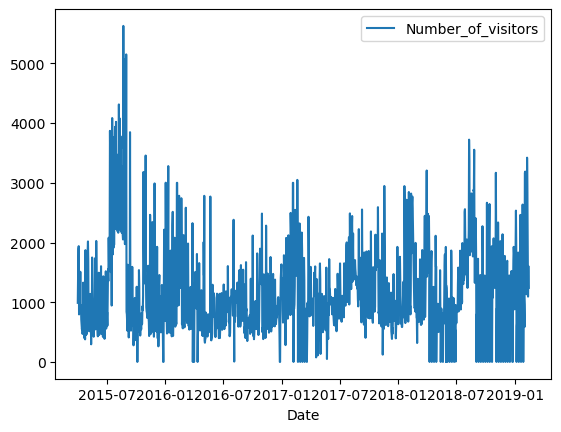

In [193]:
# loading museum visitor data - bristol museum
# https://opendata.bristol.gov.uk/datasets/98d95d36536343eca59e6e4bb04c58b7_0/explore

import datetime as dt
import matplotlib.pyplot as plt

# Load the data
df2 = pd.read_csv('data/raw/Bristol_Museums_Daily_Visitor_Numbers.csv')

# Show unique values in the 'Museum' column
print(set(df2['Museum']))

# Filter the data to only include the Bristol Museum
df2 = df2[df2['Museum'] == 'Bristol Museum']

# Convert the 'Date' column to datetime format and sort
df2['Date'] = pd.to_datetime(df2['Date']).dt.date
df2.sort_values('Date', inplace=True)

# Plot the number of visitors over time
df2.plot('Date', 'Number_of_visitors')

plt.savefig('figs/visitors_bristol.png', dpi=300)

## merge visitor data and tweets

In [194]:
# Merge with visitor data
merged_data = pd.merge(df2, tweet_summary_by_date, left_on='Date', right_on='date', how='left')
# merged_data.head()

merged_data['date'] = pd.to_datetime(merged_data['date'])

merged_data['day'] = merged_data['date'].dt.day_name()

merged_data['weekend'] = [True if x in ['Saturday', 'Sunday'] else False for x in merged_data['day']]

merged_data.head()

,Museum,Kpi,Number_of_visitors,Date,Comments,Date_Logged,ObjectId,date,self_counts,total_counts,likes_counts,retweet_counts,neutral_counts,positive_counts,negative_counts,Sentiment_value,day,weekend
0,Bristol Museum,visits,990.0,2015-04-01,NaN,2017/05/10 14:50:55.376+00,6854,2015-04-01,5.0,5.0,9.0,11.0,3.0,2.0,0.0,0.108333,Wednesday,False
1,Bristol Museum,visits,1452.0,2015-04-02,NaN,2017/05/10 14:50:55.380+00,6848,2015-04-02,4.0,9.0,22.0,42.0,3.0,0.0,6.0,-0.305556,Thursday,False
2,Bristol Museum,visits,1894.0,2015-04-03,NaN,2017/05/10 14:50:55.384+00,6842,2015-04-03,2.0,3.0,3.0,3.0,0.0,1.0,2.0,-0.066667,Friday,False
3,Bristol Museum,visits,1939.0,2015-04-04,NaN,2017/05/10 14:50:55.387+00,6836,2015-04-04,3.0,2.0,12.0,5.0,1.0,0.0,1.0,-0.083333,Saturday,True
4,Bristol Museum,visits,796.0,2015-04-05,NaN,2017/05/10 14:50:55.391+00,6830,2015-04-05,1.0,3.0,5.0,2.0,1.0,2.0,0.0,0.108333,Sunday,True


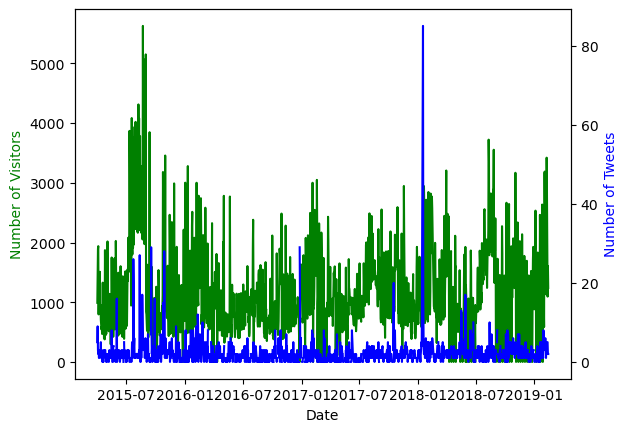

In [195]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(merged_data['Date'], merged_data['Number_of_visitors'], 'g-')
ax2.plot(merged_data['Date'], merged_data['total_counts'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Visitors', color='g')
ax2.set_ylabel('Number of Tweets', color='b')

plt.show()

# spikey- are those weekends?



In [196]:
print(merged_data.total_counts.sum()) # should be ~3000
print(len(tweets)) # should be 6281

3077.0
6281


In [197]:
# See what's causing the big spike in Jan. 2018
merged_data.sort_values('total_counts', ascending=False)
# merged_data.head()

,Museum,Kpi,Number_of_visitors,Date,Comments,Date_Logged,ObjectId,date,self_counts,total_counts,likes_counts,retweet_counts,neutral_counts,positive_counts,negative_counts,Sentiment_value,day,weekend
993,Bristol Museum,visits,1342.0,2018-01-17,the counter stopped at 4pm,2018/01/20 14:48:26.611+00,1408,2018-01-17,5.0,85.0,155.0,47.0,77.0,8.0,0.0,0.034916,Wednesday,False
167,Bristol Museum,visits,607.0,2015-09-17,NaN,2017/05/10 14:50:56.010+00,5842,2015-09-17,0.0,29.0,25.0,25.0,28.0,0.0,1.0,-0.017241,Thursday,False
634,Bristol Museum,visits,0.0,2016-12-26,NaN,2017/05/10 14:50:57.757+00,2839,2016-12-26,0.0,29.0,3.0,9.0,27.0,2.0,0.0,0.031034,Monday,False
208,Bristol Museum,visits,1315.0,2015-10-28,NaN,2017/05/10 14:50:56.163+00,5760,2015-10-28,6.0,28.0,26.0,14.0,21.0,7.0,0.0,0.153571,Wednesday,False
131,Bristol Museum,visits,2627.0,2015-08-12,NaN,2017/05/10 14:50:55.875+00,6154,2015-08-12,1.0,27.0,8.0,4.0,2.0,24.0,1.0,0.439352,Wednesday,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,Bristol Museum,visits,693.0,2018-12-13,NaN,2018/12/14 11:08:15.629+00,249,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1334,Bristol Museum,visits,1036.0,2018-12-31,md,2019/02/12 12:17:40.926+00,190,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1335,Bristol Museum,visits,1048.0,2018-12-31,NaN,2019/01/06 14:37:14.438+00,189,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1342,Bristol Museum,visits,0.0,2019-01-07,NaN,2019/02/12 12:22:44.769+00,174,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [198]:
# tweets[tweets['date'] == '2018-01-17']
# tweets

merged_data.to_csv('data/processed/bristol_museum_tweets_visitors.csv', index=False)

# TODO: maybe start the script here, and put all the stuff above into a processing py script

In [199]:
from datetime import datetime as dt

start_date = dt.strptime('2018-01-17', '%Y-%m-%d').date()
end_date = dt.strptime('2018-01-17', '%Y-%m-%d').date()
# end_date = '2018-01-31'

# TODO: fix this part
# filtered_tweets = tweets[(tweets['date'] >= start_date) & (tweets['date'] <= end_date)]

tweets.head()
# Seems that the museum sold a Banksy print without that rights and that caused the spike in tweets that day
# set(filtered_tweets['Content'])

# tweets['date']



,Name,Handle,Timestamp,Verified,Content,Comments,Retweets,Likes,Analytics,Tags,Mentions,Emojis,Profile Image,Tweet Link,Tweet ID,Content_cleaned,Sentiment,Sentiment_value,date,month
0,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-30T09:05:08.000Z,False,The Weather is cold outside but the welcome is...,0,3.0,7.0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94703078324...,tweet_id:947030783243497472,Weather cold outside welcome warmer Red Lodge,positive,0.05,2017-12-30,2017-12
1,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-29T09:00:44.000Z,False,All 'Christmas Essentials' are now 1/2 price o...,1,2.0,5.0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94666729063...,tweet_id:946667290631770112,'Christmas Essentials' now 1/2 price online sh...,neutral,0.00,2017-12-29,2017-12
2,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T16:00:55.000Z,False,In our next #WinterLecture David Olusoga explo...,0,0.0,8.0,0,['#WinterLecture'],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94641064325...,tweet_id:946410643258822656,next #WinterLecture David Olusoga explores ear...,positive,0.12,2017-12-28,2017-12
3,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T13:57:31.000Z,False,*assistance dogs that is! ^lt,0,0.0,0.0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94637958779...,tweet_id:946379587793096705,*assistance dogs is! ^lt,neutral,0.00,2017-12-28,2017-12
4,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T13:56:17.000Z,False,"Hi Marina, thanks for checking - however only ...",2,0.0,0.0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94637928036...,tweet_id:946379280363159552,"Hi Marina, thanks checking - assistance allowe...",positive,0.20,2017-12-28,2017-12


## Weather data

In [ ]:
# Get weather data

# TODO: figure out what is going on here with my conda/pip install conflicts

from meteostat import Point, Daily
from datetime import datetime
import matplotlib.pyplot as plt

# Set time period
start = datetime(2014, 1, 1)
end = datetime(2019, 12, 31)

lat = 51.454514
lon = -2.587910
alt = 36 # feet

# Create Point for Bristol
bristol = Point(lat, lon, alt)

# Get daily data for 2014-2019
data = Daily(bristol, start, end)
data = data.fetch()

data.to_csv('data/processed/climate_bristol.csv')

# lyneham has precipitation data-
data = Daily('03740', start, end)
data = data.fetch()
data.head()

data.to_csv('data/processed/climate_lyneham.csv')

,datetime,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,2014-01-01,2014-01-01,7.9,4.5,10.5,5.8,NaN,176.0,24.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-02,2014-01-02,7.3,4.9,9.3,17.5,NaN,202.0,20.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-01-03,2014-01-03,6.7,5.3,9.7,4.3,NaN,209.0,28.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-01-04,2014-01-04,5.1,1.9,7.0,10.2,NaN,193.0,11.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-01-05,2014-01-05,5.2,1.3,12.1,16.5,NaN,184.0,21.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


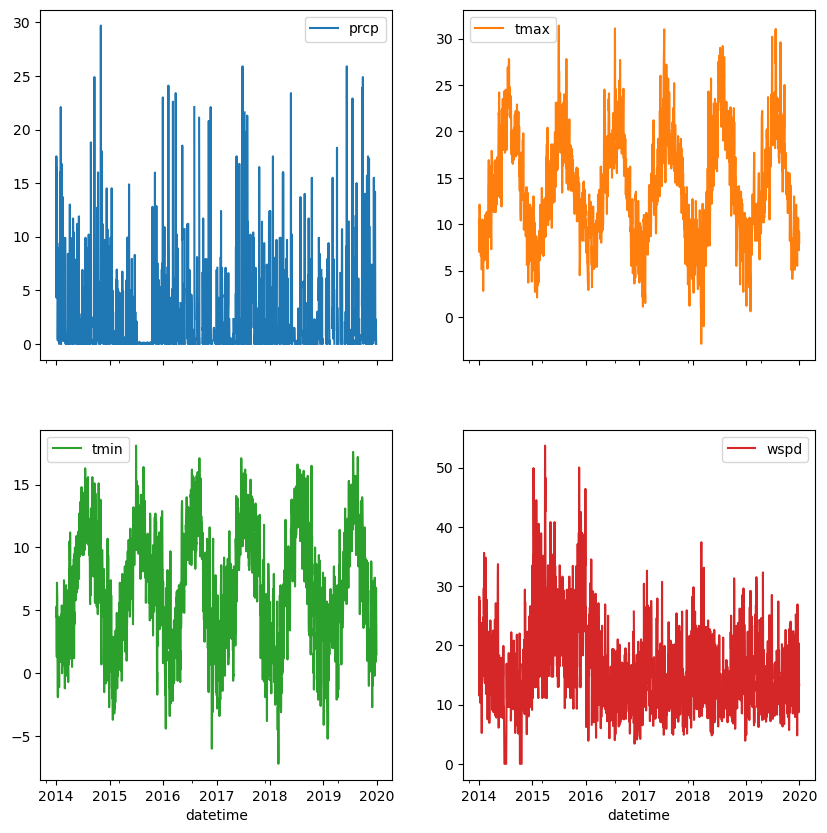

In [200]:
import matplotlib.pyplot as plt
import pandas as pd

climdat1 = pd.read_csv('data/processed/climate_lyneham.csv')
climdat1['year'] = pd.to_datetime(climdat1['time']).dt.year
climdat1['datetime'] = pd.to_datetime(climdat1['time']).dt.date

# Data from visual crossings
# https://www.visualcrossing.com/weather-history/lyneham/metric/2015-01-01/2015-12-31
# Summer 2015 had lots of NAs for the meteostat data, so here I'm replacing 2015 with this VC data
clim2015 = pd.read_csv('data/processed/lyneham 2015-01-01 to 2015-12-31.csv')

# Clean up column names
clim2015.rename(columns={'tempmax': 'tmax', 'tempmin': 'tmin', 'precip': 'prcp', 'windspeed': 'wspd'}, inplace=True)
clim2015['datetime'] = pd.to_datetime(clim2015['datetime']).dt.date

# Remove 2015
climdat1 = climdat1[climdat1['year'] != 2015]

# Set indices for concatenation
climdat1.set_index('datetime', inplace=True)
clim2015.set_index('datetime', inplace=True)

# Concatenate the data
climdat = pd.concat([climdat1, clim2015], ignore_index=False)

# climdat[['tmax', 'tmin', 'prcp', 'wspd']]

climdat.reset_index(inplace=True)

climdat = climdat.sort_values(by='datetime', ascending=True)

climdat.plot(x='datetime', y=['prcp','tmax','tmin','wspd'], subplots=True, layout=(2,2), figsize=(10,10))

# Ensure all rows increment by 1 day
all_days = pd.date_range(start=climdat['datetime'].min(), end=climdat['datetime'].max(), freq='D')
climdat = climdat.set_index('datetime').reindex(all_days).rename_axis('datetime').reset_index()

climdat.head()


    datetime        time  tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt  \
0 2014-01-01  2014-01-01   7.9   4.5  10.5   5.8   NaN  176.0  24.5   NaN   
1 2014-01-02  2014-01-02   7.3   4.9   9.3  17.5   NaN  202.0  20.4   NaN   
2 2014-01-03  2014-01-03   6.7   5.3   9.7   4.3   NaN  209.0  28.2   NaN   
3 2014-01-04  2014-01-04   5.1   1.9   7.0  10.2   NaN  193.0  11.5   NaN   
4 2014-01-05  2014-01-05   5.2   1.3  12.1  16.5   NaN  184.0  21.7   NaN   

   ...  solarenergy  uvindex  severerisk sunrise  sunset  moonphase  \
0  ...          NaN      NaN         NaN     NaN     NaN        NaN   
1  ...          NaN      NaN         NaN     NaN     NaN        NaN   
2  ...          NaN      NaN         NaN     NaN     NaN        NaN   
3  ...          NaN      NaN         NaN     NaN     NaN        NaN   
4  ...          NaN      NaN         NaN     NaN     NaN        NaN   

   conditions  description  icon  stations  
0         NaN          NaN   NaN       NaN  
1         NaN       

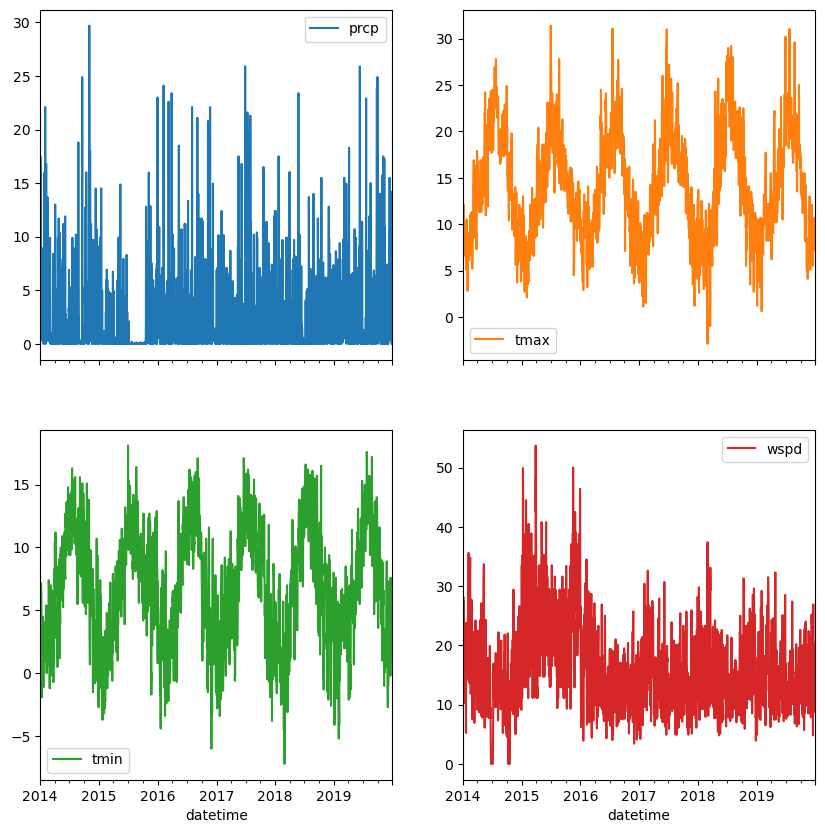

In [201]:
# impute missing precip data

import numpy as np
from sklearn.impute import KNNImputer

nan = np.nan

X = climdat[['prcp','tmax','tmin','wspd']]

imputer = KNNImputer(n_neighbors=2, weights="uniform")

tmp = imputer.fit_transform(X)

tmp = pd.DataFrame(tmp, columns=['prcp','tmax','tmin','wspd'])

# tmp.head()
# tmp.plot(subplots=True, layout=(2,2), figsize=(10,10))
# array([[1. , 2. , 4. ],
#        [3. , 4. , 3. ],
#        [5.5, 6. , 5. ],
#        [8. , 8. , 7. ]])

# print(len(tmp), len(climdat))

climdat[['prcp','tmax','tmin','wspd']] = tmp[['prcp','tmax','tmin','wspd']]

print(climdat.head())

climdat.plot(x='datetime', y=['prcp','tmax','tmin','wspd'], subplots=True, layout=(2,2), figsize=(10,10))

climdat[['datetime','prcp']].to_csv('data/processed/climdat_check.csv', index=False)

In [202]:
# add weather data to the merged data
# Convert 'time' column to datetime
climdat['time'] = pd.to_datetime(climdat['datetime']).dt.date

# Merge weather data with the merged_data DataFrame
merged_data_clim = pd.merge(merged_data, climdat, left_on='Date', right_on='time', how='left')
merged_data_clim.head()
# merged_data_clim.columns


,Museum,Kpi,Number_of_visitors,Date,Comments,Date_Logged,ObjectId,date,self_counts,total_counts,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Bristol Museum,visits,990.0,2015-04-01,NaN,2017/05/10 14:50:55.376+00,6854,2015-04-01,5.0,5.0,...,13.5,5.0,NaN,2015-04-01T06:44:04,2015-04-01T19:40:36,0.40,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"03647099999,03743099999,03746099999,0364409999..."
1,Bristol Museum,visits,1452.0,2015-04-02,NaN,2017/05/10 14:50:55.380+00,6848,2015-04-02,4.0,9.0,...,7.9,4.0,NaN,2015-04-02T06:41:48,2015-04-02T19:42:17,0.43,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"03647099999,03743099999,03746099999,0364409999..."
2,Bristol Museum,visits,1894.0,2015-04-03,NaN,2017/05/10 14:50:55.384+00,6842,2015-04-03,2.0,3.0,...,8.7,5.0,NaN,2015-04-03T06:39:32,2015-04-03T19:43:57,0.47,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"03647099999,03743099999,03746099999,0364409999..."
3,Bristol Museum,visits,1939.0,2015-04-04,NaN,2017/05/10 14:50:55.387+00,6836,2015-04-04,3.0,2.0,...,14.1,5.0,NaN,2015-04-04T06:37:17,2015-04-04T19:45:38,0.50,"Rain, Overcast",Cloudy skies throughout the day with early mor...,rain,"03743099999,03746099999,03644099999,0364909999..."
4,Bristol Museum,visits,796.0,2015-04-05,NaN,2017/05/10 14:50:55.391+00,6830,2015-04-05,1.0,3.0,...,9.1,4.0,NaN,2015-04-05T06:35:02,2015-04-05T19:47:18,0.53,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"03743099999,03746099999,03644099999,0364909999..."


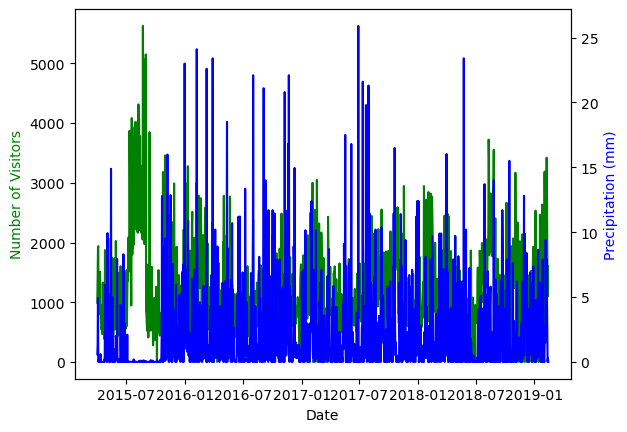

In [203]:
# Plot precipitation and visits

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(merged_data_clim['Date'], merged_data_clim['Number_of_visitors'], 'g-')
ax2.plot(merged_data_clim['Date'], merged_data_clim['prcp'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Visitors', color='g')
ax2.set_ylabel('Precipitation (mm)', color='b')

plt.show()

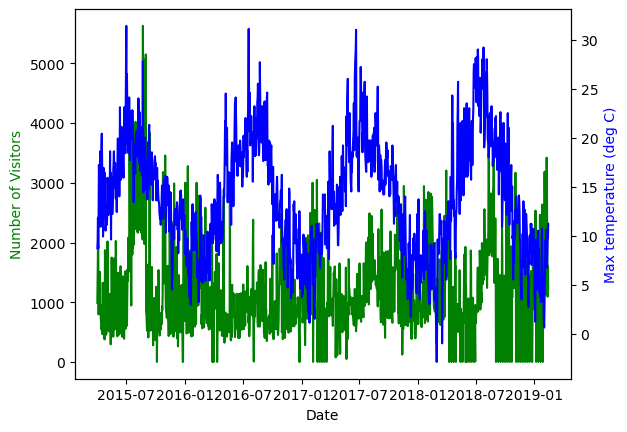

In [204]:
# Plot average temperature and museum visits

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(merged_data_clim['Date'], merged_data_clim['Number_of_visitors'], 'g-')
ax2.plot(merged_data_clim['Date'], merged_data_clim['tmax'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Visitors', color='g')
ax2.set_ylabel('Max temperature (deg C)', color='b')

plt.show()

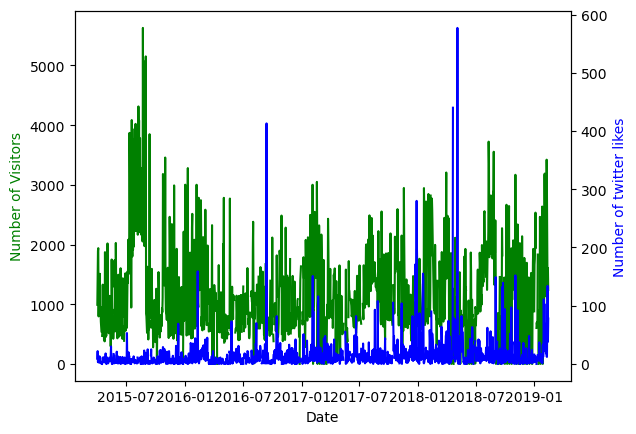

In [205]:
# Plot average temperature and museum visits

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(merged_data_clim['date'], merged_data_clim['Number_of_visitors'], 'g-')
ax2.plot(merged_data_clim['date'], merged_data_clim['likes_counts'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Visitors', color='g')
ax2.set_ylabel('Number of twitter likes', color='b')

plt.show()

## Time series decomposition

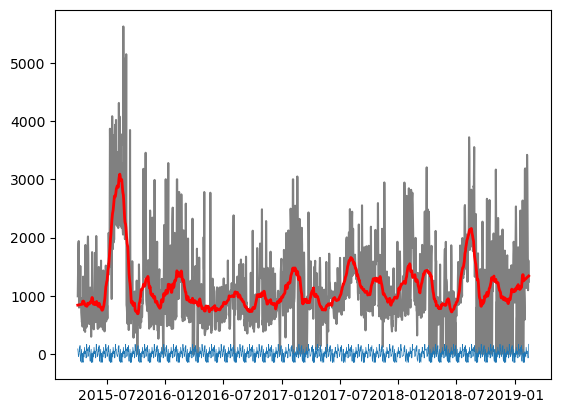

In [206]:
from statsmodels.tsa.seasonal import seasonal_decompose

# trying this out

xvar = merged_data_clim['Date']
yvar = merged_data_clim['Number_of_visitors']

ts = pd.Series(yvar.values, index=xvar)

plt.plot(ts, color='gray')

results_add = seasonal_decompose(ts, model='additive', filt=None, period=30, two_sided=True, extrapolate_trend=30)

plt.plot(results_add.trend, label='additive trend', color='red', lw=2)
plt.plot(results_add.seasonal, label='seasonal trend', lw=0.5)



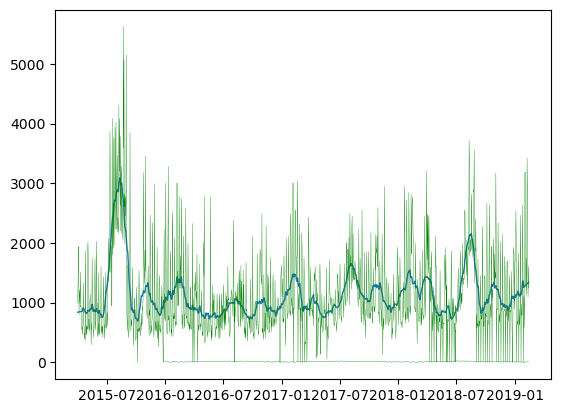

In [207]:
plt.plot(results_add.trend, label='seasonal trend', lw=1)
plt.plot(merged_data_clim['Date'], merged_data_clim['Number_of_visitors'], 'g-', lw=.25)
plt.plot(merged_data_clim['Date'], merged_data_clim['tavg'], 'g-', lw=.25)

# extract the trend
trend = results_add.trend
trend = trend.dropna()
len(trend)

# Align the trend series with the merged_data_clim DataFrame
merged_data_clim = merged_data_clim.set_index('Date')
merged_data_clim['trend'] = trend
merged_data_clim = merged_data_clim.reset_index()

# merged_data_clim.head()


## Random forest regression modeling

### Setting up all the variables

In [208]:
# what other predictors?
# i want to make a predictive model of future trends 

# what about holidays?

# what about weekends?

# what about school holidays? NOT SURE

# what about special events?

# what about unique exhibitions?
# Create a variable to indicate if dates are within certain ranges
def is_within_date_range(date, start, end):
    return start <= date <= end

# Define the date ranges for the exhibits
exhibit_ranges = [
    ('2015-10-24', '2016-03-01'),  # death: the human experience
    ('2015-07-04', '2015-09-13'),  # art in nature
    ('2015-05-16', '2015-08-31'), # hogmorth
    # '2016-04-22' # art from everywhere
    # '2016-05-21' # rembrandt
]

# Convert string dates to datetime.date objects
exhibit_ranges = [(dt.strptime(start, '%Y-%m-%d').date(), dt.strptime(end, '%Y-%m-%d').date()) for start, end in exhibit_ranges]

# Apply the function to create the 'exhibit' column
merged_data_clim['exhibit'] = merged_data_clim['Date'].apply(lambda x: any(is_within_date_range(x, start, end) for start, end in exhibit_ranges))

# what about marketing campaigns?

# what about twitter sentiment? (might need to account for a lag here)
# DONE

# what about the weather?
# DONE

# what about the day of the week?
# DONE

# what about the month?
merged_data_clim['month'] = merged_data_clim['date'].dt.month

# what about the year?
merged_data_clim['year'] = merged_data_clim['date'].dt.year

# what about the season?
# winter: December to February
# spring: March to May
# summer: June to August
# autumn: September to November
merged_data_clim['season'] = pd.cut(merged_data_clim['month'], bins=[0, 3, 6, 9, 12], labels=['winter', 'spring', 'summer', 'autumn'])

merged_data_clim['closed'] = [True if x ==0 else False for x in merged_data_clim['Number_of_visitors']]

merged_data_clim.head()

,Date,Museum,Kpi,Number_of_visitors,Comments,Date_Logged,ObjectId,date,self_counts,total_counts,...,moonphase,conditions,description,icon,stations,trend,exhibit,month,season,closed
0,2015-04-01,Bristol Museum,visits,990.0,NaN,2017/05/10 14:50:55.376+00,6854,2015-04-01,5.0,5.0,...,0.40,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"03647099999,03743099999,03746099999,0364409999...",838.215255,False,4.0,spring,False
1,2015-04-02,Bristol Museum,visits,1452.0,NaN,2017/05/10 14:50:55.380+00,6848,2015-04-02,4.0,9.0,...,0.43,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"03647099999,03743099999,03746099999,0364409999...",839.355356,False,4.0,spring,False
2,2015-04-03,Bristol Museum,visits,1894.0,NaN,2017/05/10 14:50:55.384+00,6842,2015-04-03,2.0,3.0,...,0.47,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"03647099999,03743099999,03746099999,0364409999...",840.495457,False,4.0,spring,False
3,2015-04-04,Bristol Museum,visits,1939.0,NaN,2017/05/10 14:50:55.387+00,6836,2015-04-04,3.0,2.0,...,0.50,"Rain, Overcast",Cloudy skies throughout the day with early mor...,rain,"03743099999,03746099999,03644099999,0364909999...",841.635558,False,4.0,spring,False
4,2015-04-05,Bristol Museum,visits,796.0,NaN,2017/05/10 14:50:55.391+00,6830,2015-04-05,1.0,3.0,...,0.53,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"03743099999,03746099999,03644099999,0364909999...",842.775659,False,4.0,spring,False


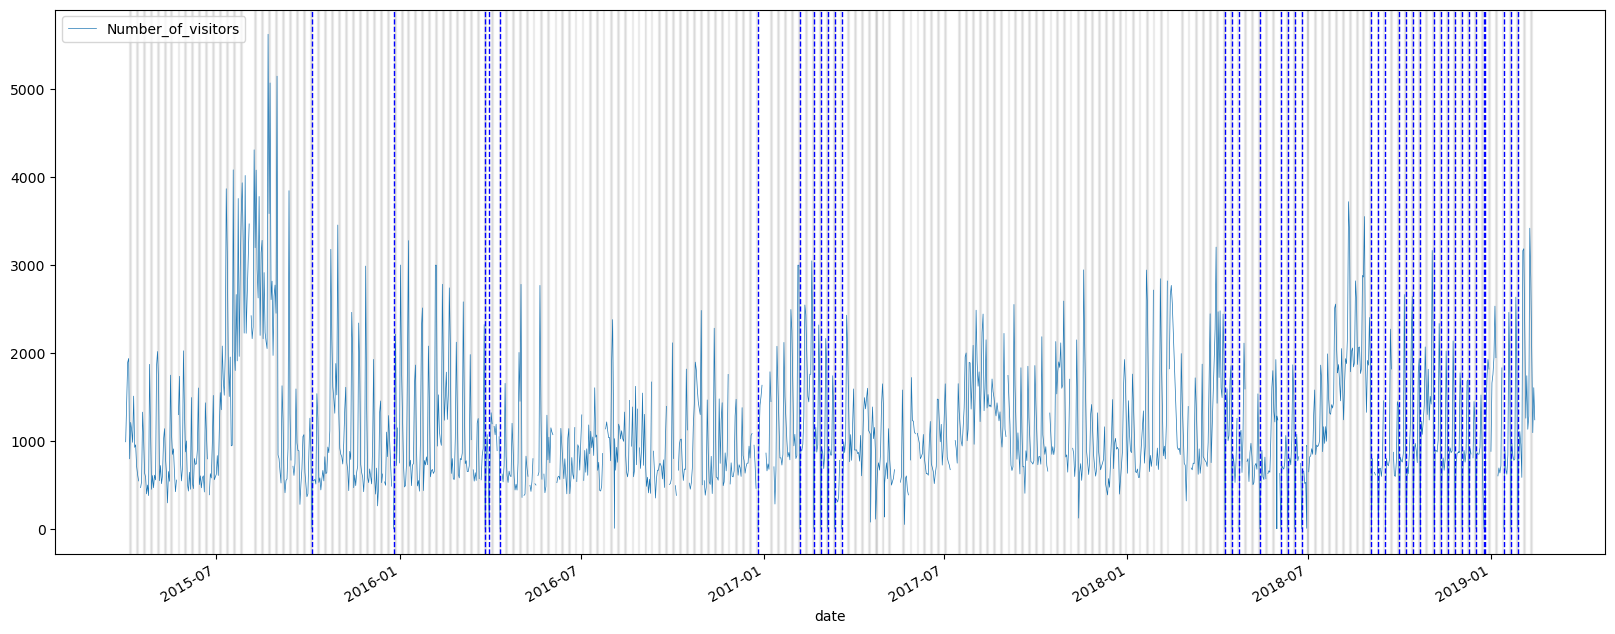

In [209]:
merged_data_clim.plot(x='date', y='Number_of_visitors', lw=0.5, figsize=(20,8))

# Add vertical lines at events
# for event in events:
#     plt.axvline(pd.to_datetime(event), color='r', linestyle='--', lw=1)

# plt.xlim(pd.to_datetime('2015-10-01'), pd.to_datetime('2016-07-01'))

# Shade the weekends
for i, row in merged_data_clim.iterrows():
    if row['weekend']:
        plt.axvspan(row['date'], row['date'] + pd.Timedelta(days=1), color='gray', alpha=0.1)

# Add vertical lines if closed is True
for i, row in merged_data_clim.iterrows():
    if row['closed']:
        plt.axvline(row['date'], color='blue', linestyle='--', lw=1)

<Axes: xlabel='fourthroot_visitors', ylabel='Count'>

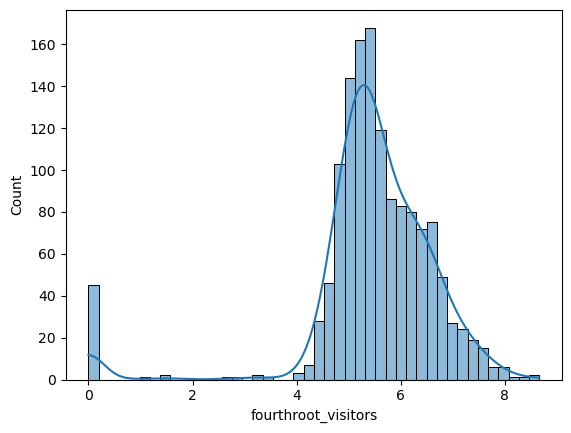

In [210]:
# Check if the number of visitors is roughly normally distributed
# sns.histplot(merged_data_clim['Number_of_visitors'], kde=True)

# log transform the number of visitors
# merged_data_clim['log_visitors'] = np.log(merged_data_clim['Number_of_visitors'])
# pow(2,2)
merged_data_clim['fourthroot_visitors'] = merged_data_clim['Number_of_visitors'].apply(lambda x: pow(x,.25))

sns.histplot(merged_data_clim['fourthroot_visitors'], kde=True)


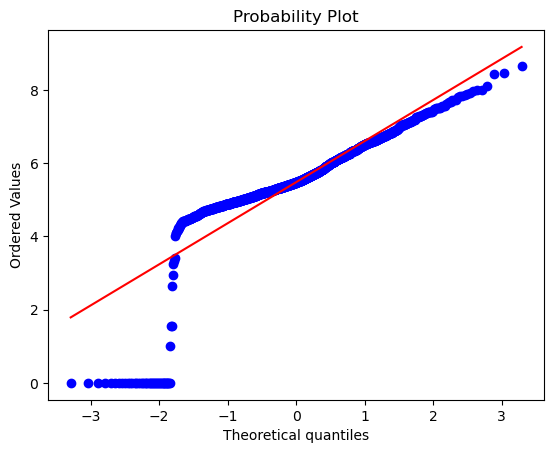

In [211]:
# make a quantiles plot
import scipy.stats as stats
import matplotlib.pyplot as plt
stats.probplot(merged_data_clim['fourthroot_visitors'], dist="norm", plot=plt)
plt.show()



<Axes: xlabel='tmax', ylabel='trend'>

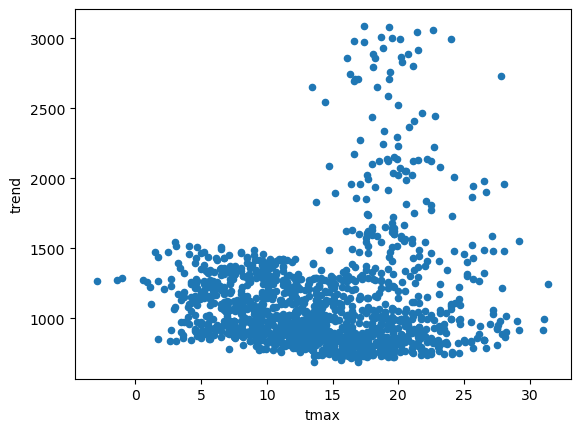

In [215]:
# merged_data_clim.plot(x='tmax', y='Number_of_visitors', kind='scatter')
merged_data_clim.plot(x='tmax', y='trend', kind='scatter')

In [216]:
# add a column
merged_data_clim['promotion'] = merged_data_clim['self_counts']
merged_data_clim['engagement'] = merged_data_clim['retweet_counts'] + merged_data_clim['likes_counts'] + merged_data_clim['total_counts']
merged_data_clim.rename(columns={'Sentiment_value': 'sentiment'}, inplace=True)

# create dummy columns for modeling below
final = pd.get_dummies(merged_data_clim, columns=['day', 'season'])

final.head()
# get list of columns
# merged_data_clim.columns

,Date,Museum,Kpi,Number_of_visitors,Comments,Date_Logged,ObjectId,date,self_counts,total_counts,...,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,season_winter,season_spring,season_summer,season_autumn
0,2015-04-01,Bristol Museum,visits,990.0,NaN,2017/05/10 14:50:55.376+00,6854,2015-04-01,5.0,5.0,...,False,False,False,False,False,True,False,True,False,False
1,2015-04-02,Bristol Museum,visits,1452.0,NaN,2017/05/10 14:50:55.380+00,6848,2015-04-02,4.0,9.0,...,False,False,False,True,False,False,False,True,False,False
2,2015-04-03,Bristol Museum,visits,1894.0,NaN,2017/05/10 14:50:55.384+00,6842,2015-04-03,2.0,3.0,...,False,False,False,False,False,False,False,True,False,False
3,2015-04-04,Bristol Museum,visits,1939.0,NaN,2017/05/10 14:50:55.387+00,6836,2015-04-04,3.0,2.0,...,False,True,False,False,False,False,False,True,False,False
4,2015-04-05,Bristol Museum,visits,796.0,NaN,2017/05/10 14:50:55.391+00,6830,2015-04-05,1.0,3.0,...,False,False,True,False,False,False,False,True,False,False


In [217]:
# figure out where there are gaps in days
# merged_data_clim['date'].diff().plot()

final.loc[121]

Date                      2015-07-31
Museum                Bristol Museum
Kpi                           visits
Number_of_visitors            2225.0
Comments                         NaN
                           ...      
day_Wednesday                  False
season_winter                  False
season_spring                  False
season_summer                   True
season_autumn                  False
Name: 121, Length: 75, dtype: object

### Clean the data set

In [235]:
# Select relevant variables
# selected_columns = ['date', 'weekend', 'Number_of_visitors', 'exhibit', 'promotion', 'sentiment', 'engagement', 'closed', 'prcp', 'tmin', 'tmax', 'wspd']
selected_columns = ['date', 'weekend', 'Number_of_visitors', 'exhibit', 'promotion', 'sentiment', 'engagement', 'closed', 'prcp', 'tmin', 'tmax', 'wspd', 'day_Monday','day_Tuesday','day_Wednesday','day_Thursday','day_Friday','day_Saturday','day_Sunday', 'season_spring', 'season_summer', 'season_autumn', 'season_winter'] 
# selected_columns = ['date', 'day', 'weekend', 'Number_of_visitors', 'exhibit', 'promotion', 'engagement', 'closed', 'tavg', 'tmin', 'tmax', 'wspd', 'season']

# Don't drop NAs
cleaned_data = final[selected_columns]

# Drop NAs
# cleaned_data = final[selected_columns].dropna()

cleaned_data.head()

# merged_data_clim[selected_columns].isna().sum()


,date,weekend,Number_of_visitors,exhibit,promotion,sentiment,engagement,closed,prcp,tmin,...,day_Tuesday,day_Wednesday,day_Thursday,day_Friday,day_Saturday,day_Sunday,season_spring,season_summer,season_autumn,season_winter
0,2015-04-01,False,990.0,False,5.0,0.108333,25.0,False,0.591,2.7,...,False,True,False,False,False,False,True,False,False,False
1,2015-04-02,False,1452.0,False,4.0,-0.305556,73.0,False,1.390,5.2,...,False,False,True,False,False,False,True,False,False,False
2,2015-04-03,False,1894.0,False,2.0,-0.066667,9.0,False,4.943,7.4,...,False,False,False,True,False,False,True,False,False,False
3,2015-04-04,True,1939.0,False,3.0,-0.083333,19.0,False,0.002,6.1,...,False,False,False,False,True,False,True,False,False,False
4,2015-04-05,True,796.0,False,1.0,0.108333,10.0,False,0.000,6.1,...,False,False,False,False,False,True,True,False,False,False


In [236]:
final[selected_columns].isna().sum()

date                   72
weekend                 0
Number_of_visitors      0
exhibit                 0
promotion              72
sentiment             305
engagement             73
closed                  0
prcp                    0
tmin                    0
tmax                    0
wspd                    0
day_Monday              0
day_Tuesday             0
day_Wednesday           0
day_Thursday            0
day_Friday              0
day_Saturday            0
day_Sunday              0
season_spring           0
season_summer           0
season_autumn           0
season_winter           0
dtype: int64

In [ ]:
# cleaned_data = pd.get_dummies(cleaned_data, columns=['day', 'season'])
# cleaned_data = pd.get_dummies(cleaned_data, columns=['day'])
# cleaned_data.head()

### Partition the data into training and test data sets

In [237]:
from sklearn.model_selection import train_test_split

# Randomly split 20% of rows as testing (or validation) and the other as training
train_data, test_data = train_test_split(cleaned_data, test_size=0.2, random_state=42)

# Selecting columns for regressions
X_train = train_data.drop(columns=['date', 'Number_of_visitors'])
y_train = train_data['Number_of_visitors']

X_test = test_data.drop(columns=['date', 'Number_of_visitors'])
y_test = test_data['Number_of_visitors']

len(train_data), len(test_data)

(1103, 276)

### Fit a decision tree regressor model

In [238]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

# Do decision tree regression
dtree = DecisionTreeRegressor(max_depth=7, random_state=42)
dtree.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=7, random_state=42)

In [239]:
# Output R2, MSE for training and testing data-

# training data
pred_train_tree = dtree.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_tree)))
print(r2_score(y_train, pred_train_tree))

# validation/testing data
pred_test_tree = dtree.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_tree))) 
print(r2_score(y_test, pred_test_tree))


384.8337552065043
0.7197090729049893
564.3064100197665
0.37365897877552035


In [986]:
# TODO: learn how to do this with tensorflow decision forests

# import tensorflow as tf
# import tensorflow_decision_forests as tfdf

# Convert datasetes into TensorFlow datasets
# train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label='Number_of_visitors')
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label='Number_of_visitors')



### Fit a random forest regression model

#### hyperparameter tuning

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}
rf = RandomForestRegressor()

rand_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, cv=5, verbose=0, random_state=42)

rand_search.fit(X_train, y_train)

#### Fit model

In [240]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

model_rf = RandomForestRegressor(n_estimators=5000, oob_score=True, random_state=100, min_samples_leaf=2)
model_rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=2, n_estimators=5000, oob_score=True,
                      random_state=100)

In [241]:
# extract R2, model fits
pred_train_rf= model_rf.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print(r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print(r2_score(y_test, pred_test_rf))

262.9141390510115
0.8691750409658352
504.5676542875082
0.49925144857407266


$R^2$ is 86.9 for the training set (not bad??), but $R^2$ for the test data is rather low at 49.9%. I probably need to take a look at what's going on there.

#### Plot the predicted and actual number of visitors for the RF model

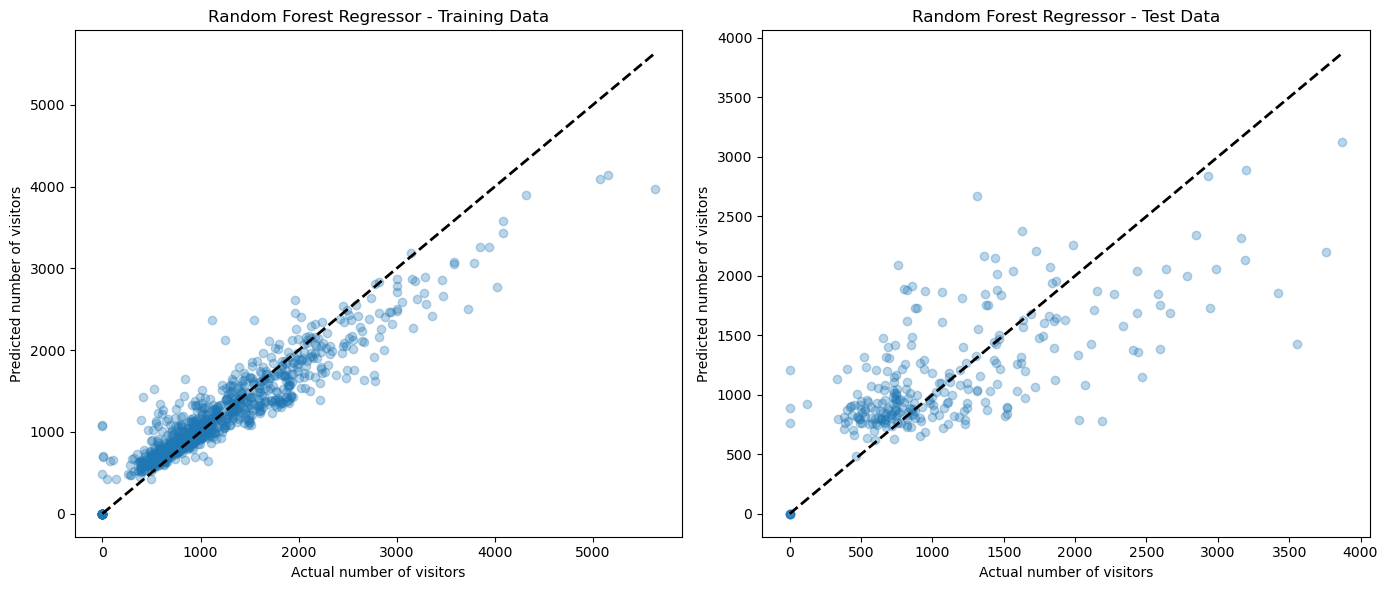

In [242]:
# Setup figure
plt.figure(figsize=(14, 6))

# Plotting the training data predictions
plt.subplot(1, 2, 1)
plt.scatter(y_train, pred_train_rf, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel('Actual number of visitors')
plt.ylabel('Predicted number of visitors')
plt.title('Random Forest Regressor - Training Data')

# Plotting the test data predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test, pred_test_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual number of visitors')
plt.ylabel('Predicted number of visitors')
plt.title('Random Forest Regressor - Test Data')

# Some layout updates
plt.tight_layout()
plt.show()

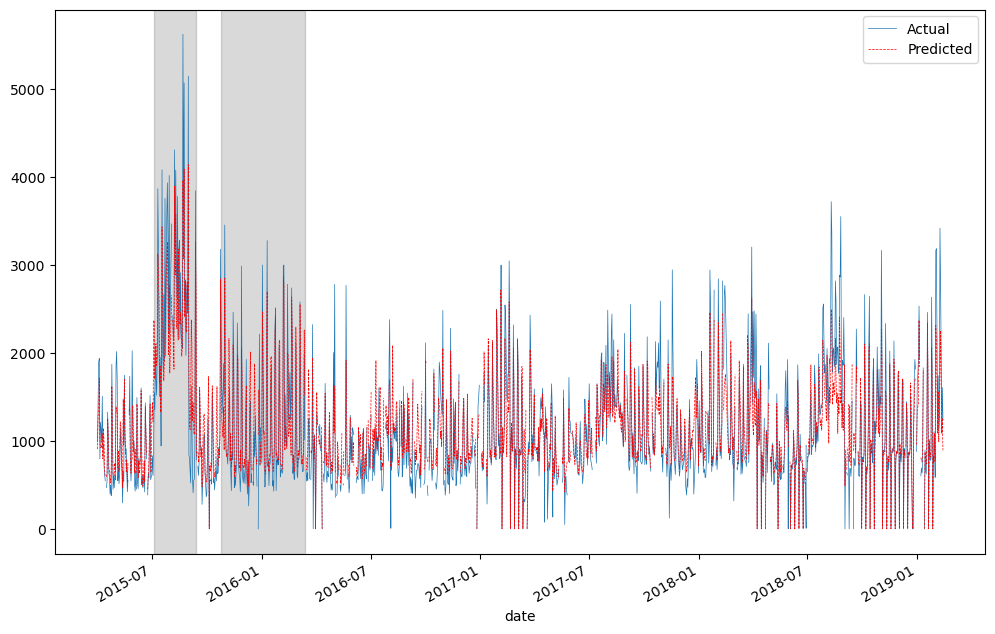

In [243]:
# Plot actual and predicted values

# plt.scatter(merged_data_clim['date'], pred_train_rf, alpha=0.3)
# X_train.index

# TODO: probably would be better to write a function that prepares the data set for RF modeling

# Merge the training and testing data
tmp = pd.concat([X_train, X_test], axis=0)

tmp = tmp.loc[merged_data_clim.index]

# merged_data_clim.index

# Get predictions and add to the main data set
merged_data_clim['predicted_visitors'] = model_rf.predict(tmp)

# Plots
merged_data_clim.plot(x='date', y='Number_of_visitors', lw=0.5, figsize=(12,8), kind='line')
plt.plot(merged_data_clim['date'], merged_data_clim['predicted_visitors'], lw=0.5, color='red', linestyle='--')

# Optionally limit to a time range
# plt.xlim(pd.to_datetime('2018-08-01'), pd.to_datetime('2018-08-31'))

# Add a legend
plt.legend(['Actual', 'Predicted'])

# Add vertical lines at new years
# for year in range(2015, 2020):
#     plt.axvline(pd.to_datetime(f'{year}-01-01'), color='gray', linestyle='--', lw=1)

# Add shaded box for range of dates
axes = plt.gcf().get_axes()
for ax in axes:
    ax.axvspan(pd.to_datetime('2015-10-24'), pd.to_datetime('2016-03-13'), color='black', alpha=0.15) # death: the human experience
    ax.axvspan(pd.to_datetime('2015-07-04'), pd.to_datetime('2015-09-13'), color='black', alpha=0.15) # art forms in nature exhibit

plt.savefig('figs/visitors_predicted.png', dpi=300)



In [284]:
# Best day for visitor numbers

feature_names = X_test.columns

# final.sort_values('Number_of_visitors', ascending=False)[feature_names].head()

maxValueIndex = final['Number_of_visitors'].idxmax(axis=0)
minValueIndex = final['Number_of_visitors'].idxmin(axis=0)

rowMax = final.loc[[maxValueIndex]][feature_names]
rowMin = final.loc[[minValueIndex]][feature_names]

/Users/chad/github/museum_twitter/scraper/waterfall_chart.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop] + row['amount']
/Users/chad/github/museum_twitter/scraper/waterfall_chart.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop]


<module 'matplotlib.pyplot' from '/Users/chad/miniconda3/lib/python3.10/site-packages/matplotlib/pyplot.py'>

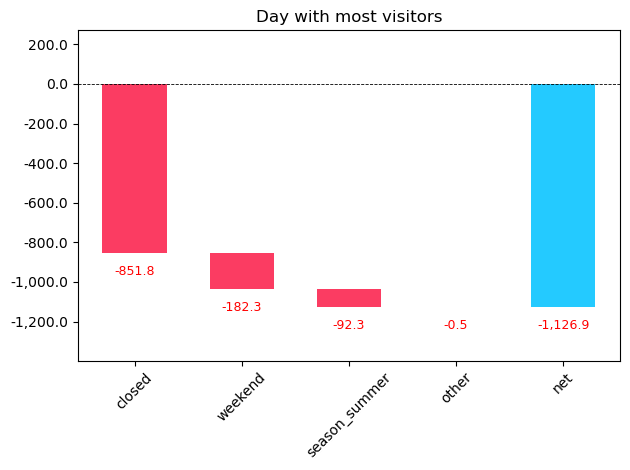

In [332]:
# contributions[0]

# bias

# changes = {'amount': contributions[0]}

# trans = pd.DataFrame(data=changes)
# blank = trans.amount.cumsum().shift(1).fillna(0)

# plt.barh(feature_names, contributions[0])

# trans, blank

# blank + bias

del waterplot

from scraper.waterfall_chart import waterplot

waterplot(X_test.columns, contributions[0], threshold=0.05, 
          rotation_value=45, formatting='{:,.1f}', sorted_value=True,
          Title="Day with most visitors")


In [347]:
maxdate = final.loc[maxValueIndex].Date.strftime('%Y-%m-%d')
mindate = final.loc[minValueIndex].Date.strftime('%Y-%m-%d')

bias

array([1126.93063862])

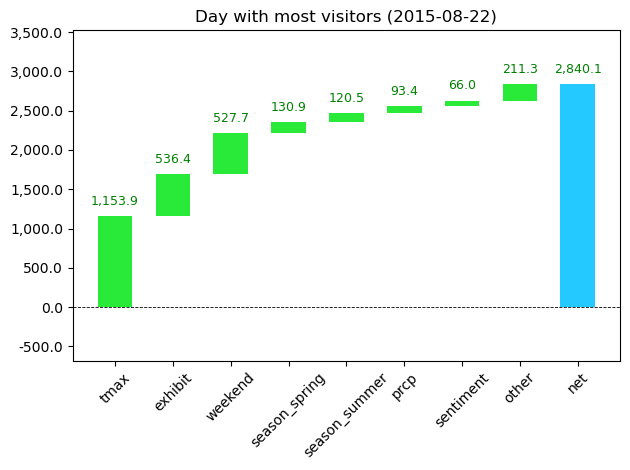

In [345]:
# figure out what's going on using waterfall charts

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall
import warnings

warnings.filterwarnings('ignore', module='waterfall_chart')

# Max values waterfall plot
row = rowMax
prediction, bias, contributions = treeinterpreter.predict(model_rf, row.values)

fig = waterfall(X_test.columns, contributions[0], threshold=0.05, 
          rotation_value=45, formatting='{:,.1f}', sorted_value=True,
          Title="Day with most visitors" + f" ({maxdate})")

fig.savefig('figs/waterfall_max.png', dpi=300)


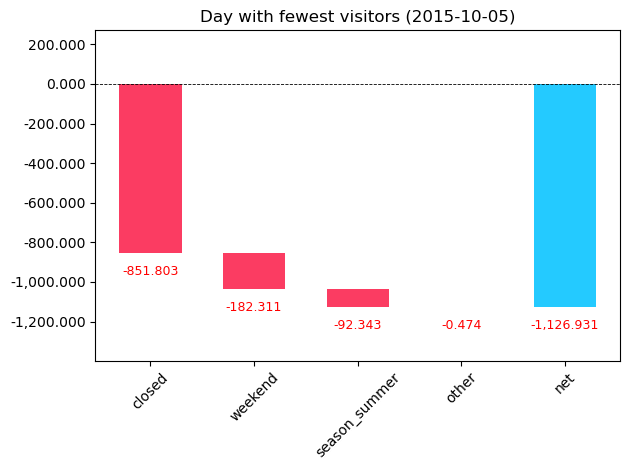

In [346]:
# Min values waterfall plot
row = rowMin
prediction, bias, contributions = treeinterpreter.predict(model_rf, row.values)
fig = waterfall(X_test.columns, contributions[0], threshold=0.05, 
          rotation_value=45, formatting='{:,.3f}', sorted_value=True,
          Title="Day with fewest visitors" + f" ({mindate})")

fig.savefig('figs/waterfall_min.png', dpi=300)

In [61]:
# see if ther are any gaps in days
merged_data_clim.date.diff().dt.days.value_counts()
# this shows that there are 36 2-day gaps and 16 0-day gaps (??)


date
1.0    1187
2.0      36
0.0      16
3.0       2
4.0       2
5.0       1
Name: count, dtype: int64

In [70]:
# Looking at where the zeros come from
merged_data_clim[merged_data_clim['Number_of_visitors'] == 0].groupby('day').size()
# most are Mondays, looking online that's when the museum is often closed (but not always as seen in the time series above)

day
Monday       34
Saturday      1
Sunday        1
Thursday      1
Tuesday       1
Wednesday     1
dtype: int64

#### Look at RF decision tree

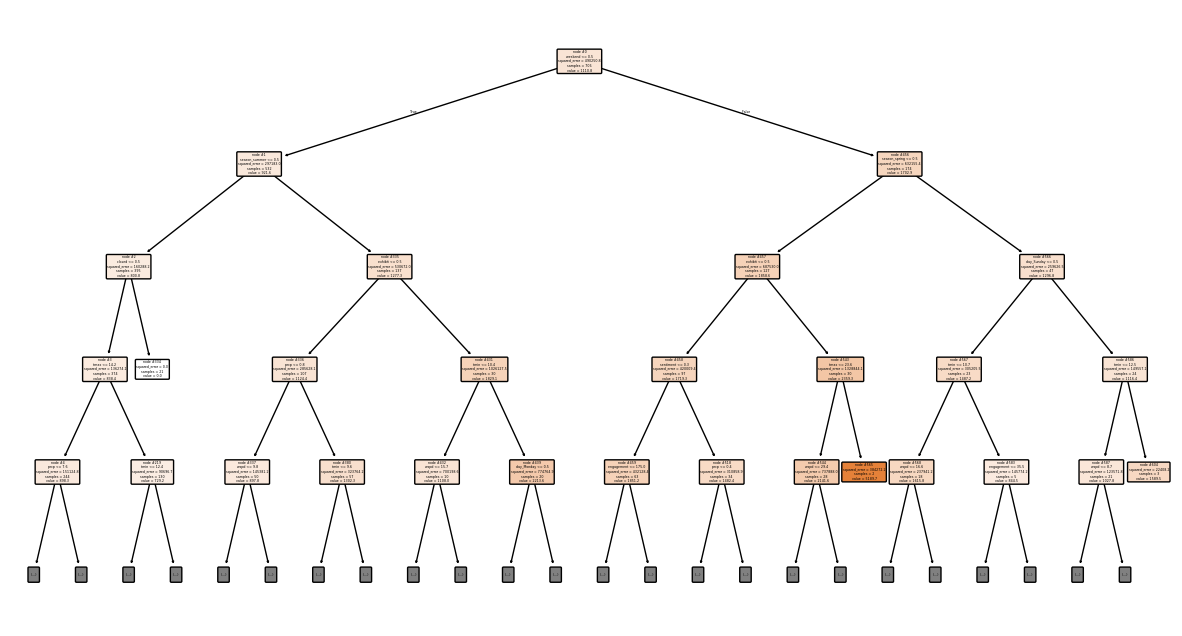

In [83]:
from sklearn import tree

# import pybaobabdt

# Get the feature names
feature_names = X_train.columns

# Pick the first tree from the forest
dtree1 = model_rf.estimators_[0]

# Plot the tree
plt.figure(figsize=(15, 8))
tree.plot_tree(dtree1, feature_names=feature_names, max_depth=4, filled=True, node_ids=True, rounded=True, precision=1)

# text_representation = tree.export_text(dtree1, feature_names=feature_names)
# print(text_representation)

plt.savefig('figs/tree.png', dpi=600)

# Another way
# m = dtreeviz.model(dtree1, X_train, y_train, feature_names=feature_names, target_name='Number_of_visitors')
# m.view(depth_range_to_display=[0,1,2])


#### Get feature importances

In [114]:
importances = model_rf.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

          Feature  Importance
0         weekend    0.198178
8            tmax    0.107071
1         exhibit    0.107047
7            tmin    0.079703
3       sentiment    0.071808
19  season_summer    0.071445
9            wspd    0.065747
6            prcp    0.062180
4      engagement    0.057100
5          closed    0.051616
18  season_spring    0.038388
2       promotion    0.031070
11     day_Monday    0.016510
17  season_winter    0.012977
20  season_autumn    0.006201
12   day_Saturday    0.005642
13     day_Sunday    0.005249
10     day_Friday    0.003519
14   day_Thursday    0.003514
16  day_Wednesday    0.002758
15    day_Tuesday    0.002276


In [115]:
# range of visitors per day
merged_data_clim['Number_of_visitors'].min(), merged_data_clim['Number_of_visitors'].max()

(0.0, 5628.0)

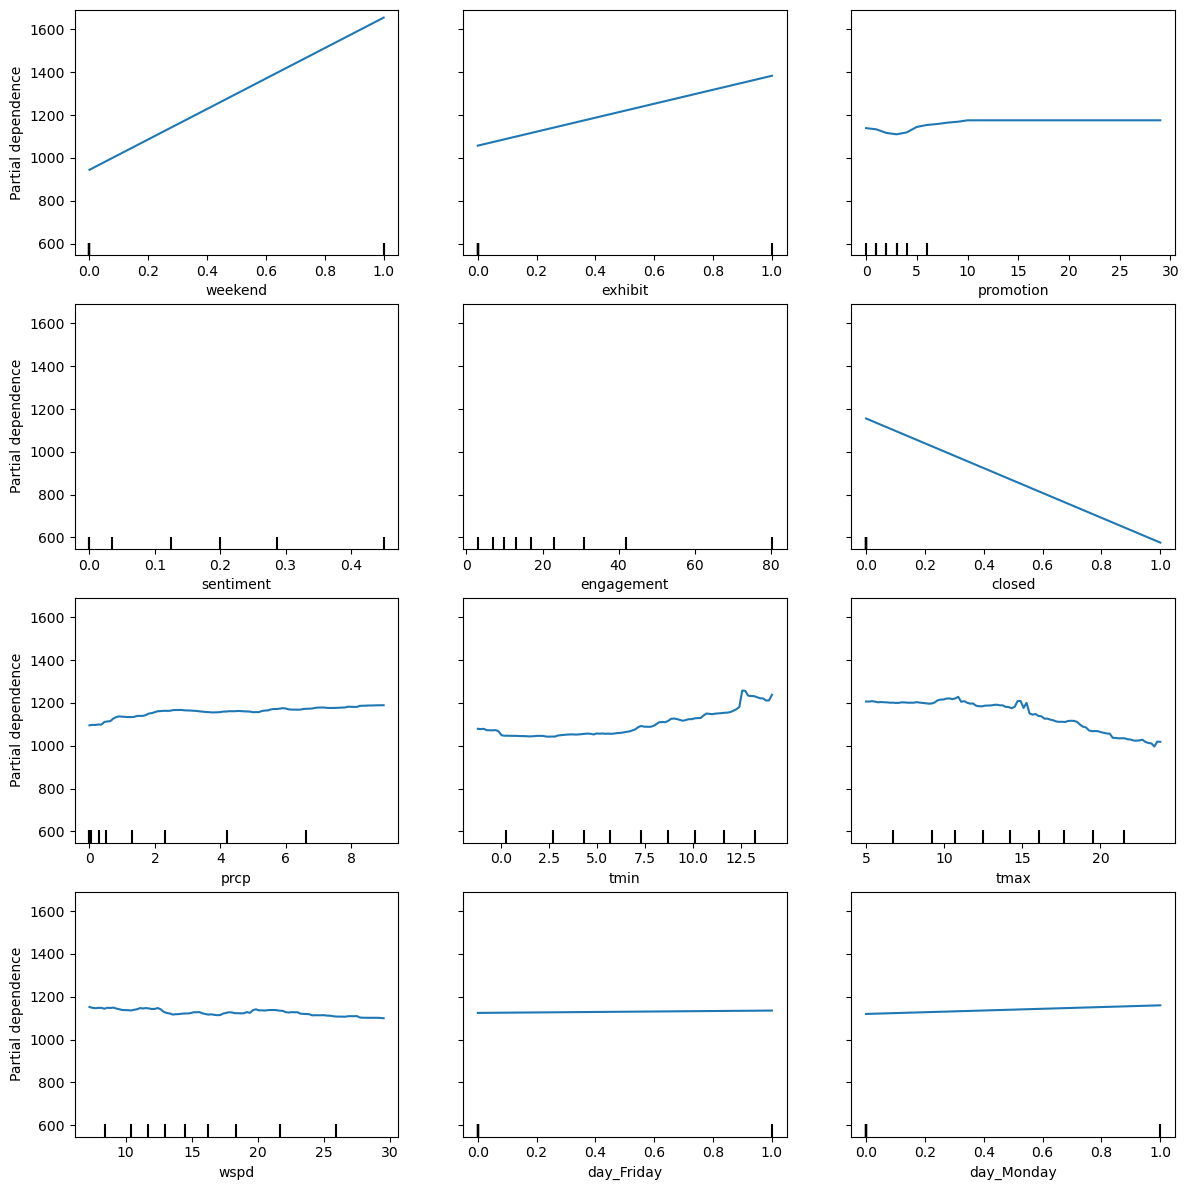

In [116]:
from sklearn.inspection import PartialDependenceDisplay

fig = PartialDependenceDisplay.from_estimator(model_rf, X_train, range(12)).figure_

fig.set_figwidth(12)
fig.set_figheight(12)
fig.tight_layout()


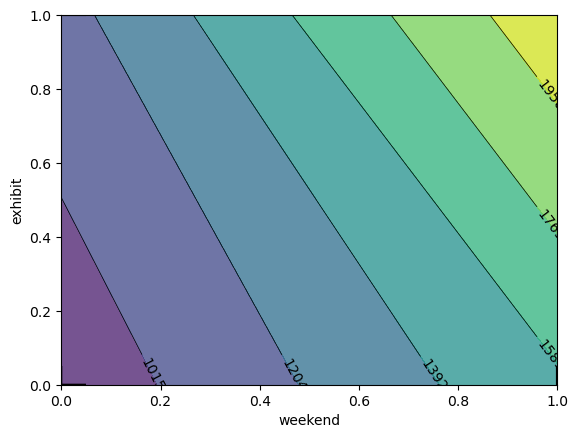

In [85]:

# print(X_train.columns)
fig = PartialDependenceDisplay.from_estimator(model_rf, X_train, [('weekend', 'exhibit')]).figure_
fig.savefig('figs/pdp_weekend.png', dpi=300)

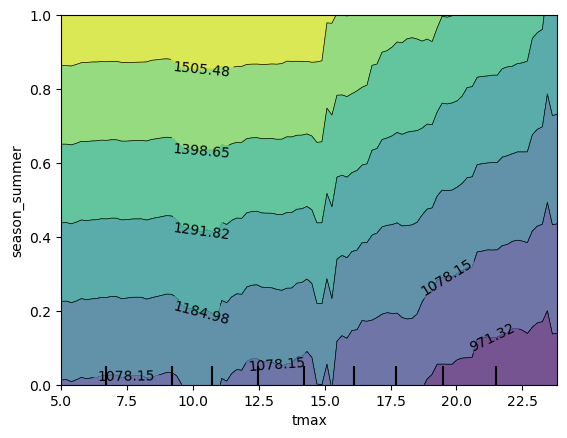

In [86]:
fig = PartialDependenceDisplay.from_estimator(model_rf, X_train, [('tmax', 'season_summer')]).figure_
fig.savefig('figs/pdp_summer_tmax.png', dpi=300)

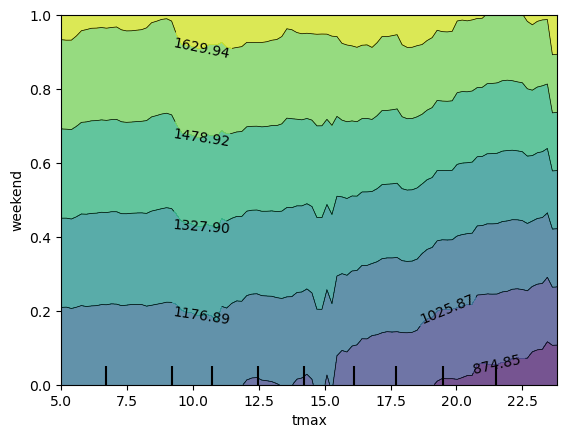

In [87]:
fig = PartialDependenceDisplay.from_estimator(model_rf, X_train, [('tmax', 'weekend')]).figure_
fig.savefig('figs/pdp_weekend_tmax.png', dpi=300)
# PartialDependenceDisplay.from_estimator(model_rf, X_train, [('promotion', 'exhibit')])

29.0

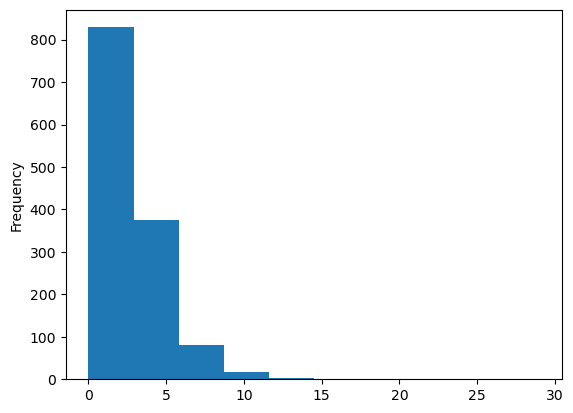

In [1562]:
# model_rf.predict(X_train.iloc[0:2,:])

# X_train['promotion'].isna().sum(), X_train['sentiment'].isna().sum(), X_train['engagement'].isna().sum()

merged_data_clim['promotion'].plot(kind='hist')

merged_data_clim['promotion'].max()
